<a href="https://colab.research.google.com/github/RollinPumpkin/BigData2025/blob/main/UTS_Big_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark findspark


In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import numpy as np
import time
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("MatrixMultiplicationUTS").getOrCreate()

In [7]:
def matrix_multiply_spark(spark, matrix_a, matrix_b, num_partitions):
    rdd_a = spark.sparkContext.parallelize(matrix_a.tolist(), num_partitions).zipWithIndex()
    rdd_b = spark.sparkContext.parallelize(matrix_b.T.tolist(), num_partitions).zipWithIndex()

    result = rdd_a.cartesian(rdd_b) \
        .map(lambda x: ((x[0][1], x[1][1]), sum(a*b for a,b in zip(x[0][0], x[1][0])))) \
        .reduceByKey(lambda a, b: a + b) \
        .map(lambda x: (x[0][0], (x[0][1], x[1]))) \
        .groupByKey() \
        .map(lambda x: (x[0], sorted(list(x[1]), key=lambda y: y[0]))) \
        .sortByKey() \
        .map(lambda x: [v for (i,v) in x[1]])

    return np.array(result.collect())


In [8]:
def test_all():
    sizes = [1000, 2000]  # Bisa kamu tambah jika RAM mencukupi
    workers = [5, 10, 20]
    results = []

    for size in sizes:
        A = np.random.rand(size, size)
        B = np.random.rand(size, size)

        for w in workers:
            start = time.time()
            matrix_multiply_spark(spark, A, B, w)
            end = time.time()
            results.append((size, w, end - start))
            print(f"Size: {size}, Workers: {w}, Time: {end-start:.2f}s")

    return results

spark_results = test_all()


Size: 1000, Workers: 5, Time: 259.20s
Size: 1000, Workers: 10, Time: 369.93s
Size: 1000, Workers: 20, Time: 835.94s
Size: 2000, Workers: 5, Time: 1264.70s
Size: 2000, Workers: 10, Time: 1622.37s
Size: 2000, Workers: 20, Time: 2415.07s


In [9]:
sequential_results = []
for size in [1000, 2000]:
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)
    start = time.time()
    np.dot(A, B)
    end = time.time()
    sequential_results.append((size, 1, end - start))
    print(f"Sequential {size}x{size}: {end - start:.2f}s")


Sequential 1000x1000: 0.08s
Sequential 2000x2000: 0.44s


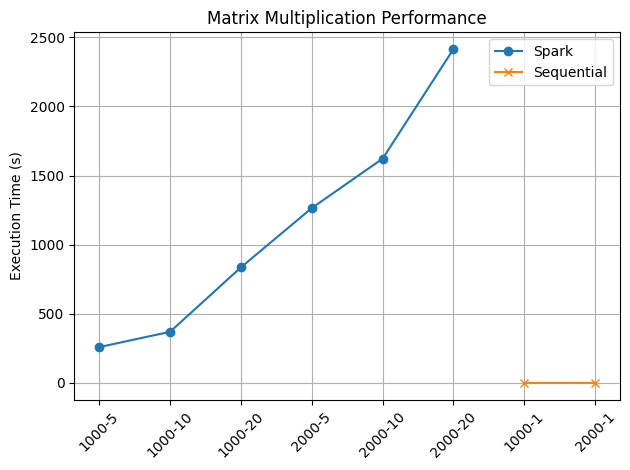

In [10]:
fig, ax = plt.subplots()
x_labels = [f"{s}-{w}" for (s, w, _) in spark_results]
y_vals = [t for (_, _, t) in spark_results]
ax.plot(x_labels, y_vals, marker='o', label="Spark")
ax.plot([f"{s}-1" for (s, _, _) in sequential_results],
        [t for (_, _, t) in sequential_results],
        marker='x', label="Sequential")
plt.xticks(rotation=45)
plt.ylabel("Execution Time (s)")
plt.title("Matrix Multiplication Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
